# EECE5644 Summer 1 2022 - Practice Problems

Going through Assignment 0 for practice. Imports for notebook:

In [1]:
import matplotlib.pyplot as plt # For general plotting

import numpy as np

from scipy.stats import multivariate_normal # MVN not univariate
from sklearn.metrics import confusion_matrix

np.set_printoptions(suppress=True)

# Set seed to generate reproducible "pseudo-randomness" (handles scipy's "randomness" too)
np.random.seed(7)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize
plt.rc('figure', titlesize=22)  # fontsize of the figure title

## Question 1

Design a classifier that achieves minimum probability of error for a three-class problem where the class priors are respectively $P(L=1)=0.15$, $P(L=2)=0.35$, $P(L=3)=0.5$ and the class-conditional data distributions are all Gaussians for two-dimensional data vectors:

\begin{equation*}
\mathcal{N}(\begin{bmatrix}-1\\0\end{bmatrix},\begin{bmatrix}1 & -0.4\\-0.4 & 0.5\end{bmatrix}) 
\quad
\mathcal{N}(\begin{bmatrix}1\\0\end{bmatrix},\begin{bmatrix}0.5 & 0\\0 & 0.2\end{bmatrix})
\quad
\mathcal{N}(\begin{bmatrix}0\\1\end{bmatrix},\begin{bmatrix}0.1 & 0\\0 & 0.1\end{bmatrix})
\end{equation*}

Generate 10000 samples according to this data distribution, keep track of the true class labels for each sample. 

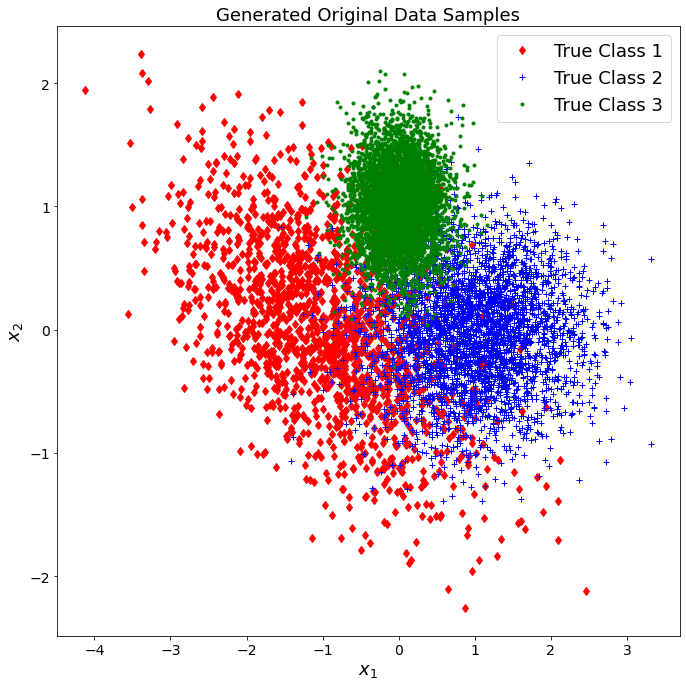

In [2]:
N = 10000

# Mean and covariance of data pdfs conditioned on labels
mu = np.array([[-1, 0],
               [1, 0],
               [0, 1]])  # Gaussian distributions means
Sigma = np.array([[[1, -0.4],
                   [-0.4, 0.5]],
                  [[0.5, 0],
                   [0, 0.2]],
                  [[0.1, 0],
                   [0, 0.1]]])  # Gaussian distributions covariance matrices
# Determine dimensionality from mixture PDF parameters
n = mu.shape[1]

# Class priors
priors = np.array([0.15, 0.35, 0.5])  
C = len(priors)
# Decide randomly which samples will come from each component
u = np.random.rand(N)
thresholds = np.cumsum(priors)
thresholds = np.insert(thresholds, 0, 0) # For intervals of classes

# Output samples and labels
X = np.zeros([N, n])
labels = np.zeros(N) # KEEP TRACK OF THIS

# Plot for original data and their true labels
fig = plt.figure(figsize=(10, 10))
marker_shapes = 'd+.'
marker_colors = 'rbg' 

L = np.array(range(1, C+1))
for l in L:
    # Get randomly sampled indices for this component
    indices = np.argwhere((thresholds[l-1] <= u) & (u <= thresholds[l]))[:, 0]
    # No. of samples in this component
    Nl = len(indices)  
    labels[indices] = l * np.ones(Nl)
    X[indices, :] =  multivariate_normal.rvs(mu[l-1], Sigma[l-1], Nl)
    plt.plot(X[labels==l, 0], X[labels==l, 1], marker_shapes[l-1] + marker_colors[l-1], label="True Class {}".format(l))

    
# Plot the original data and their true labels
plt.legend()
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("Generated Original Data Samples")
plt.tight_layout()
plt.show()

Apply your optimal classifier designed as described above to this dataset and obtain decision labels for each sample. Report the following:

- Actual number of samples that were generated from each class;

In [3]:
Nl = np.array([sum(labels == l) for l in L])
print("Number of samples from Class 1: {:d}, Class 2: {:d}, Class 3: {:d}".format(Nl[0], Nl[1], Nl[2]))

Number of samples from Class 1: 1527, Class 2: 3516, Class 3: 4957


- The confusion matrix for your classifier consisting of number of samples decided as class $r\in\{1,2,3\}$ when their true labels were class $c\in\{1,2,3\}$, using $r,c$ as row/column indices; 
- The total number of samples misclassified by your classifier; 
- An estimate of the probability of error your classifier will achieves, based on these samples; 

Need to develop our optimal classifier first! Reminder that the min. probability of error (follows from conditional risk and law of total probability) is:

\begin{align*}
D(\mathbf{x}) & = \mathop{\rm argmin}_{r\in \{0, 1, 2\}} \sum_{r \neq c} P(Y = c \, | \, \mathbf{x})\\
& = \mathop{\rm argmin}_{r\in \{0, 1, 2\}} 1 - P(Y = r \, | \, \mathbf{x}) \\
&= \mathop{\rm argmax}_{r\in \{0, 1, 2\}} P(Y = r \, | \, \mathbf{x})
\end{align*}

In [4]:
# Min prob. of error classifier
# Conditional likelihoods of each class given x, shape (C, N)
class_cond_likelihoods = np.array([multivariate_normal.pdf(X, mu[c], Sigma[c]) for c in range(C)])
# Take diag so we have (C, C) shape of priors with prior prob along diagonal
class_priors = np.diag(priors)
# class_priors*likelihood with diagonal matrix creates a matrix of posterior probabilities
# with each class as a row and N columns for samples, e.g. row 1: [p(y1)p(x1|y1), ..., p(y1)p(xN|y1)]
class_posteriors = class_priors.dot(class_cond_likelihoods)

# MAP rule, take largest class posterior per example as your decisions matrix (N, 1)
# Careful of indexing! Added np.ones(N) just for difference in starting from 0 in Python and labels={1,2,3}
decisions = np.argmax(class_posteriors, axis=0) + np.ones(N) 

# Simply using sklearn confusion matrix
print("Confusion Matrix (rows: Predicted class, columns: True class):")
conf_mat = confusion_matrix(decisions, labels)
print(conf_mat)
correct_class_samples = np.sum(np.diag(conf_mat))
print("Total Mumber of Misclassified Samples: {:d}".format(N - correct_class_samples))

# Alternatively work out probability error based on incorrect decisions per class
# perror_per_class = np.array(((conf_mat[1,0]+conf_mat[2,0])/Nl[0], (conf_mat[0,1]+conf_mat[2,1])/Nl[1], (conf_mat[0,2]+conf_mat[1,2])/Nl[2]))
# prob_error = perror_per_class.dot(Nl.T / N)

prob_error = 1 - (correct_class_samples / N)
print("Empirically Estimated Probability of Error: {:.4f}".format(prob_error))

Confusion Matrix (rows: Predicted class, columns: True class):
[[1228  133   23]
 [ 200 3171   99]
 [  99  212 4835]]
Total Mumber of Misclassified Samples: 766
Empirically Estimated Probability of Error: 0.0766


- A visualization of the data as a 2-dimensional scatter plot, with true labels and decision labels indicated using two separate visulization cues, such as marker shape and marker color; 

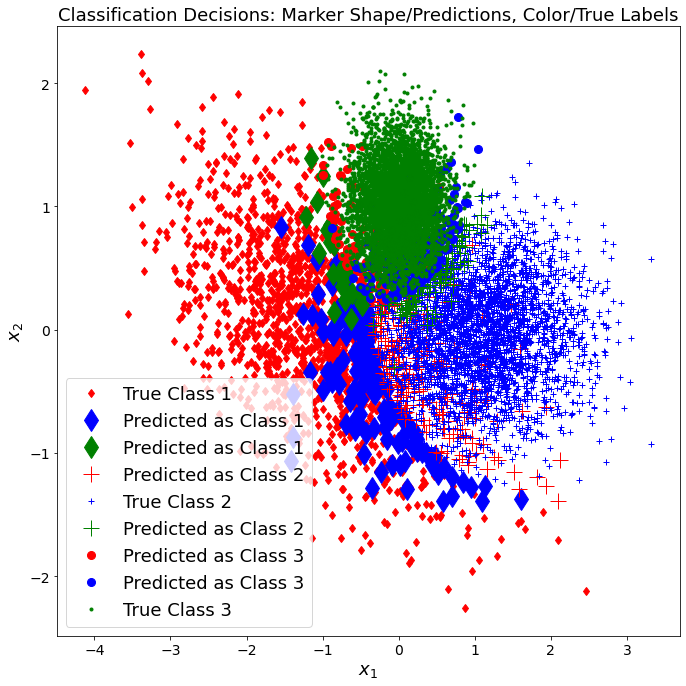

In [5]:
# Plot for decisions vs true labels
fig = plt.figure(figsize=(10, 10))

for r in L: # Each decision option
    for c in L: # Each class label
        ind_rc = np.argwhere((decisions==r) & (labels==c))

        # Decision = Marker Shape; True Labels = Marker Color
        marker = marker_shapes[r-1] + marker_colors[c-1]
        if r == c:
            plt.plot(X[ind_rc, 0], X[ind_rc, 1], marker, label="True Class {}".format(c))
        else:
            plt.plot(X[ind_rc, 0], X[ind_rc, 1], marker, markersize=16, label="Predicted as Class {}".format(r))

plt.legend()
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("Classification Decisions: Marker Shape/Predictions, Color/True Labels")
plt.tight_layout()
plt.show()

- A clear but brief description of the results presented as described above;

The confusion matrix and minimum probability of error estimate demonstrates high classification performance, with a low mislcassification rate. The graph further validates this claim and as one would expect, shows that classification performance is mostly hampered where the Gaussian class-conditional pdfs overlap.

## Question 2

Consider a scalar real-valued feature x that has the following probability distributions under two class labels as follows:

\begin{equation*}
    \ p(x|l=1) = 
        \begin{cases} 
            x       & \text{if} \; 0 \leq x < 1 \\
            2-x     & \text{if} \; 1 \leq x \leq 2 \\
            0       & \text{otherwise}
        \end{cases}
        ~~~~~~~~
        p(x|l=2) = 
        \begin{cases} 
            2x-3    & \text{if} \; \frac{3}{2} \leq x \leq \frac{5}{2} \\
            0       & \text{otherwise}
        \end{cases}
    \
\end{equation*}

### Minimum Expected Loss Classification
Let loss values be set to $Loss(\text{Decide }i\text{ when truth is }j) = \lambda_{ij} \geq 0$ for $i,j \in {1,2}$, with loss of erroneous decisions assigned to be greater than corresponding correct decisions. Let the class priors be $q_1=p(l=1)$ and $q_2=p(l=2)$, respectively. Express the minimum expected loss decision rule with a discriminant function that is simplified as much as possible. Show your steps.

###  Maximum a Posteriori Classification
For the case when 0-1 loss assignments are used, the minimum expected risk classifier reduces to the maximum a posteriori classification rule. For this case, express the maximum a posteriori classification rule.

### Maximum Likelihood Classification
In addition to 0-1 loss assignments, assume that the class priors are equal. In this case, ML classification achieves minimum expected risk. For this case, express the maximum likelihood classification rule.

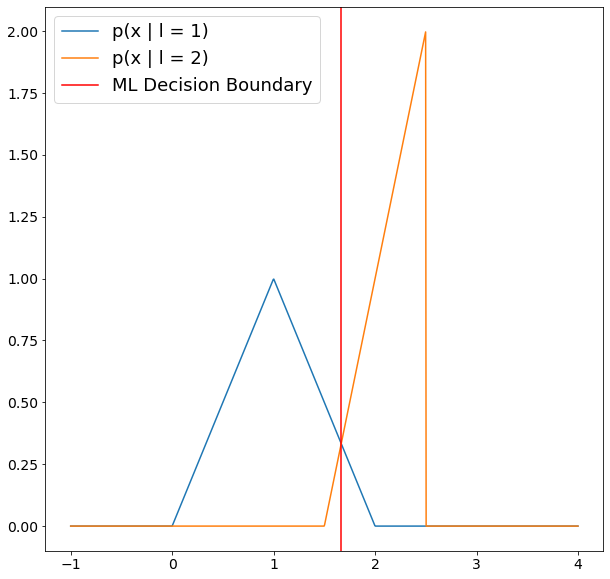

In [6]:
fig = plt.figure(figsize=(10, 10))

x = np.linspace(-1, 4, 1000)
px_l1 = np.zeros(len(x))
px_l1[(0 <= x) & (x < 1)] = x[(0 <= x) & (x < 1)]
px_l1[(1 <= x) & (x <= 2)] = 2 - x[(1 <= x) & (x <= 2)]
plt.plot(x, px_l1, label="p(x | l = 1)")

px_l2 = np.zeros(len(x))
px_l2[(1.5 <= x) & (x <= 2.5)] = 2*x[(1.5 <= x) & (x <= 2.5)] - 3
plt.plot(x, px_l2, label="p(x | l = 2)")

# For ML case where priors equal...
plt.axvline(x=5/3, color='r', label="ML Decision Boundary")

plt.legend()
plt.show()

## Question 3

Generate $N$ iid random 2-dimensional samples from two Gaussian pdfs $\mathcal{N}(\mathbf{\mu}_i,\mathbf{\Lambda}_i)$ with specified prior class probabilities $q_i$ for $i \in {0,1}$. Set:

\begin{equation*}
    \mathbf{\mu}_0 = \begin{bmatrix} -1 \\ 0 \end{bmatrix}
    ~~~~
    \mathbf{\mu}_1 = \begin{bmatrix} 1 \\ 0 \end{bmatrix}
    ~~~~
    \mathbf{\Lambda}_0 = \begin{bmatrix} 16 & 0 \\ 0 & 1 \end{bmatrix}
    ~~~~
    \mathbf{\Lambda}_1 = \begin{bmatrix} 1 & 0 \\ 0 & 16 \end{bmatrix}
\end{equation*}

Make sure to keep track of the true label of each sample. In the numerical results use $N=10000$, $q_0=0.35$, and $q_1=0.65$. 

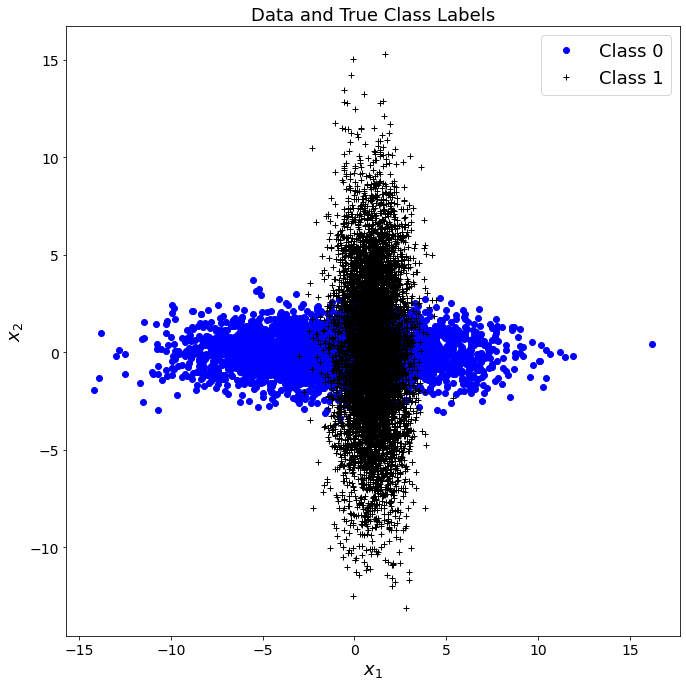

In [7]:
# Mean and covariance of data pdfs conditioned on labels
mu = np.array([[-1, 0],
               [1, 0]])  # Gaussian distributions means
Sigma = np.array([[[16, 0],
                   [0, 1]],
                  [[1, 0],
                   [0, 16]]])  # Gaussian distributions covariance matrices

# Determine dimensionality from mixture PDF parameters
n = mu.shape[1]

# Class priors
priors = np.array([0.35, 0.65])  
C = len(priors)
# Decide randomly which samples will come from each component (taking class 1 from standard normal values above 0.35)
labels = np.random.rand(N) >= priors[0]
L = np.array(range(C))
Nl = np.array([sum(labels == l) for l in L])

# Draw samples from each class pdf
X = np.zeros((N, n))
X[labels == 0, :] =  multivariate_normal.rvs(mu[0], Sigma[0], Nl[0])
X[labels == 1, :] =  multivariate_normal.rvs(mu[1], Sigma[1], Nl[1])


# Plot the original data and their true labels
fig = plt.figure(figsize=(10, 10))
plt.plot(X[labels==0, 0], X[labels==0, 1], 'bo', label="Class 0")
plt.plot(X[labels==1, 0], X[labels==1, 1], 'k+', label="Class 1")

plt.legend()
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("Data and True Class Labels")
plt.tight_layout()
plt.show()

For the following two classification methods, generate two sets of classification decisions for different values of their respective thresholds. For each classifier, plot the estimated false-positive and true-positive probabilities for each value of the threshold; overlay the two curves in the same plot for easy visual comparison.

## Minimum Expected Loss Classifier for Two Gaussian Classes
Determine and implement the minimum expected loss classifier parametrized by a threshold $\gamma$ in the following form:

\begin{equation*}
ln~p(\mathbf{x};\mathbf{\mu}_1,\mathbf{\Lambda}_1) - ln~p(\mathbf{x};\mathbf{\mu}_0,\mathbf{\Lambda}_0) \begin{matrix} \text{Decide 1} \\ ~~~~>~~~~ \\ ~~~~<~~~~ \\ \text{Decide 0} \end{matrix} ln~\gamma
\end{equation*}
    
where $\gamma > 0$ is a scalar that depends on loss and prior values. Here class 1 is <i>positive</i> and class 0 is <i>negative</i>.

As no loss matrix has been specified, we can assume <b>0-1 loss</b>, such that each incorrect classification result is equally costly. The decision rule we thus wish to derive achieves minimum probability of error (<b>MAP classification rule</b>). The decision rule that achieves minimum probability of error would use the following loss matrix:

$$ \mathbf{\Lambda} = \begin{bmatrix} 0 & 1 \\ 1 & 0 \end{bmatrix}. $$

In [8]:
# MAP classifier (is a special case of ERM corresponding to 0-1 loss)
# 0-1 loss values yield MAP decision rule
Lambda = np.ones((C, C)) - np.identity(C)
print(Lambda)

[[0. 1.]
 [1. 0.]]


Also remember the above <b>likelihood-ratio test</b> expresses threshold $\gamma$ as the right-hand side of this decision rule: 

\begin{equation*}
\frac{p(\mathbf{x};\mathbf{\mu}_1,\mathbf{\Lambda}_1)}{p(\mathbf{x};\mathbf{\mu}_0,\mathbf{\Lambda}_0)} \begin{matrix} \text{Decide 1} \\ ~~~~>~~~~ \\ ~~~~<~~~~ \\ \text{Decide 0} \end{matrix} \frac{(\lambda_{21} - \lambda_{11})}{(\lambda_{12} - \lambda_{22})} \frac{P(y_1)}{P(y_2)}
\end{equation*}

where we have not yet taken the logs. Note that evaluating these $\lambda_{ij}$ entries from the $\mathbf{\Lambda} $ matrix is unnecessary as we know ERM reduces to MAP for 0-1 loss. Try removing the loss matrix entries in the below $\gamma$ threshold calculation and you'll obtain the same threshold. Let's compute the decision threshold for MAP:

In [9]:
# Expected Risk Minimization Classifier (using true model parameters)
# In practice the parameters would be estimated from training samples
# Using log-likelihood-ratio as the discriminant score for ERM
class_conditional_likelihoods = np.array([multivariate_normal.pdf(X, mu[l], Sigma[l]) for l in L])
discriminant_score_erm = np.log(class_conditional_likelihoods[1]) - np.log(class_conditional_likelihoods[0])

# Gamma threshold for MAP decision rule (remove Lambdas and you obtain same gamma on priors only; 0-1 loss simplification)
gamma_map = (Lambda[1,0] - Lambda[0,0]) / (Lambda[0,1] - Lambda[1,1]) * priors[0]/priors[1]
# Same as:
# gamma_map = priors[0]/priors[1]
print(gamma_map)

0.5384615384615384


Plot the estimated false-positive and true-positive probabilities for each value of the threshold:

(2,)


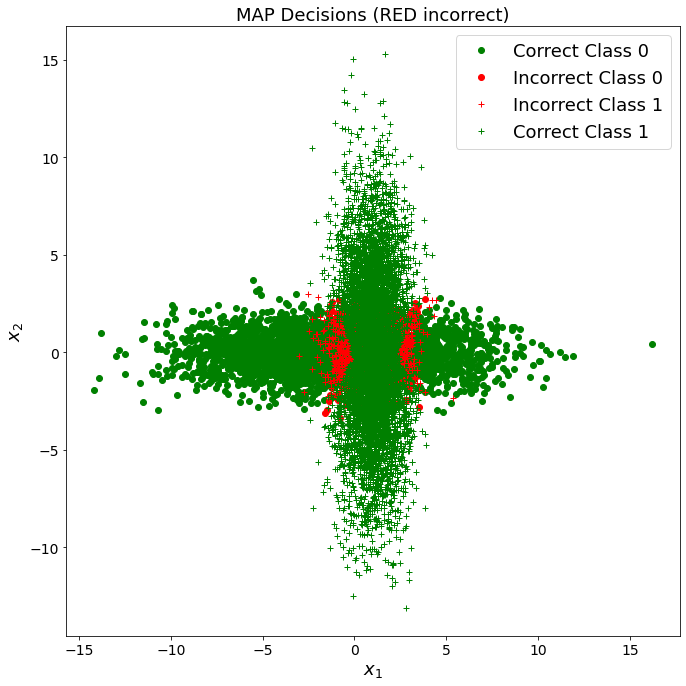

In [10]:
decisions_map = discriminant_score_erm >= np.log(gamma_map)

# Get indices and probability estimates of the four decision scenarios:
# (true negative, false positive, false negative, true positive)

# True Negative Probability
ind_00_map = np.argwhere((decisions_map==0) & (labels==0))
p_00_map = len(ind_00_map) / Nl[0]
# False Positive Probability
ind_10_map = np.argwhere((decisions_map==1) & (labels==0))
p_10_map = len(ind_10_map) / Nl[0]
# False Negative Probability
ind_01_map = np.argwhere((decisions_map==0) & (labels==1))
p_01_map = len(ind_01_map) / Nl[1]
# True Positive Probability
ind_11_map = np.argwhere((decisions_map==1) & (labels==1))
p_11_map = len(ind_11_map) / Nl[1]

# Probability of error for MAP classifier, empirically estimated
prob_error_erm = np.array((p_10_map, p_01_map)).dot(Nl.T / N)
print(np.array((p_10_map, p_01_map)).shape)
# Display MAP decisions
fig = plt.figure(figsize=(10, 10))

# class 0 circle, class 1 +, correct green, incorrect red
plt.plot(X[ind_00_map, 0], X[ind_00_map, 1], 'og', label="Correct Class 0")
plt.plot(X[ind_10_map, 0], X[ind_10_map, 1], 'or', label="Incorrect Class 0")
plt.plot(X[ind_01_map, 0], X[ind_01_map, 1], '+r', label="Incorrect Class 1")
plt.plot(X[ind_11_map, 0], X[ind_11_map, 1], '+g', label="Correct Class 1")

plt.legend()
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("MAP Decisions (RED incorrect)")
plt.tight_layout()
plt.show()

Make the $\gamma$ threshold take many values along the positive real axis, and for each threshold value, classify every sample, empirically estimate the true positive and false positive probabilities (by counting samples that fall in each category), then plotting the true-positive versus false-positive performance at each threshold in a plot. Sweep the positive real axis by sampling densely to see the true-positive vs false-positive curves for the classifier in detail.

Let's define an ROC curve-generating function:

In [11]:
from sys import float_info # Threshold smallest positive floating value

# Generate ROC curve samples
def estimate_roc(discriminant_score, label):
    Nlabels = np.array((sum(label == 0), sum(label == 1)))

    sorted_score = sorted(discriminant_score)

    # Use tau values that will account for every possible classification split
    taus = ([sorted_score[0] - float_info.epsilon] + 
             sorted_score +
             [sorted_score[-1] + float_info.epsilon])

    # Calculate the decision label for each observation for each gamma
    decisions = [discriminant_score >= t for t in taus]

    ind10 = [np.argwhere((d==1) & (label==0)) for d in decisions]
    p10 = [len(inds)/Nlabels[0] for inds in ind10]
    ind11 = [np.argwhere((d==1) & (label==1)) for d in decisions]
    p11 = [len(inds)/Nlabels[1] for inds in ind11]

    # ROC has FPR on the x-axis and TPR on the y-axis
    roc = np.array((p10, p11))

    return roc, taus

And now plot the ROC curve:

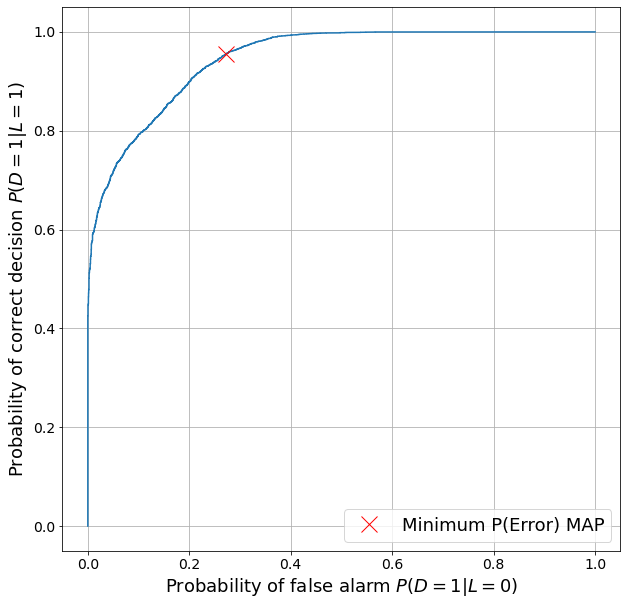

In [12]:
# Construct the ROC for ERM by changing log(gamma)
roc_erm, _ = estimate_roc(discriminant_score_erm, labels)
roc_map = np.array((p_10_map, p_11_map))

fig_roc, ax_roc = plt.subplots(figsize=(10, 10))
ax_roc.plot(roc_erm[0], roc_erm[1])
ax_roc.plot(roc_map[0], roc_map[1], 'rx', label="Minimum P(Error) MAP", markersize=16)
ax_roc.legend()
ax_roc.set_xlabel(r"Probability of false alarm $P(D=1|L=0)$")
ax_roc.set_ylabel(r"Probability of correct decision $P(D=1|L=1)$")
plt.grid(True)

fig_roc;

## Fisher Linear Discriminant Analysis for Two Gaussian Classes

Implement the Fisher LDA classifier using the true mean vectors and covariance matrices provided above to obtain a classifier $\gamma$ in the following form:

\begin{equation*}
\mathbf{w}^\text{T} \mathbf{x} \begin{matrix} \text{Decide 1} \\ ~~~~>~~~~ \\ ~~~~<~~~~ \\ \text{Decide 0} \end{matrix} \gamma
\end{equation*}

where $\gamma \in (-\inf,\inf)$.

In [13]:
def perform_lda(X, mu, Sigma, C=2):
    """  Fisher's Linear Discriminant Analysis (LDA) on data from two classes (C=2).

    In practice the mean and covariance parameters would be estimated from training samples.
    
    Args:
        X: Real-valued matrix of samples with shape [N, n], N for sample count and n for dimensionality.
        mu: Mean vector [C, n].
        Sigma: Covariance matrices [C, n, n].

    Returns:
        w: Fisher's LDA project vector, shape [n, 1].
        z: Scalar LDA projections of input samples, shape [N, 1].
    """
    
    mu = np.array([mu[i].reshape(-1, 1) for i in range(C)])
    cov = np.array([Sigma[i].T for i in range(C)])

    # Determine between class and within class scatter matrix
    Sb = (mu[1] - mu[0]).dot((mu[1] - mu[0]).T)
    Sw = cov[0] + cov[1]

    # Regular eigenvector problem for matrix Sw^-1 Sb
    lambdas, U = np.linalg.eig(np.linalg.inv(Sw).dot(Sb))
    # Get the indices from sorting lambdas in order of increasing value, with ::-1 slicing to then reverse order
    idx = lambdas.argsort()[::-1]

    # Extract corresponding sorted eigenvectors
    U = U[:, idx]

    # First eigenvector is now associated with the maximum eigenvalue, mean it is our LDA solution weight vector
    w = U[:, 0]

    # Scalar LDA projections in matrix form
    z = X.dot(w)

    return w, z

Repeat the exercise in the previous section, this time assigning many values to this threshold parameter, estimating the true- and false-positive probabilities from data classification label matches and mismatches, and plotting the true-positive versus false-positive performance curves as the threshold changes. Overlay this curve on top of the previous one.

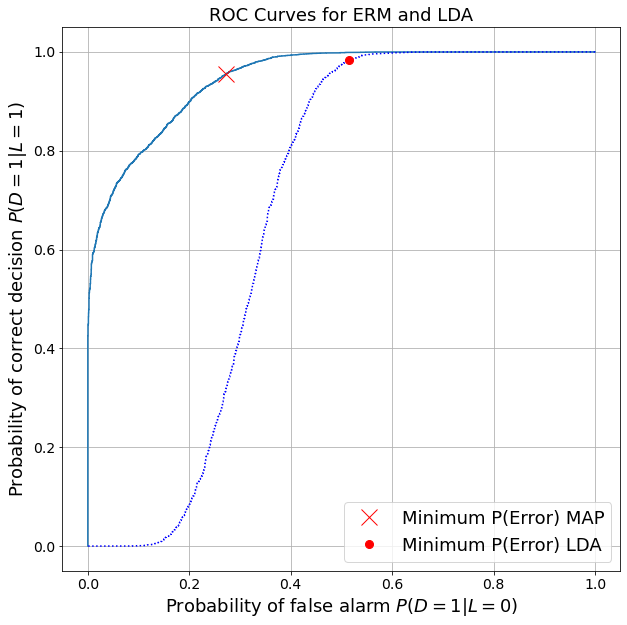

In [14]:
# Fisher LDA Classifer (using true model parameters)
_, discriminant_score_lda = perform_lda(X, mu, Sigma)

# Estimate the ROC curve for this LDA classifier
roc_lda, tau_lda = estimate_roc(discriminant_score_lda, labels)

# ROC returns FPR vs TPR, but prob error needs FNR so take 1-TPR
prob_error_lda = np.array((roc_lda[0,:], 1 - roc_lda[1,:])).T.dot(Nl.T / N)

# Min prob error
min_prob_error_lda = np.min(prob_error_lda)
min_ind = np.argmin(prob_error_lda)

# Display the estimated ROC curve for LDA and indicate the operating points
# with smallest empirical error probability estimates (could be multiple)
ax_roc.plot(roc_lda[0], roc_lda[1], 'b:')
ax_roc.plot(roc_lda[0, min_ind], roc_lda[1, min_ind], 'r.', label="Minimum P(Error) LDA", markersize=16)
ax_roc.set_title("ROC Curves for ERM and LDA")
ax_roc.legend()

fig_roc

Comment on the minimum probability of error estimates obtained for each classifier:

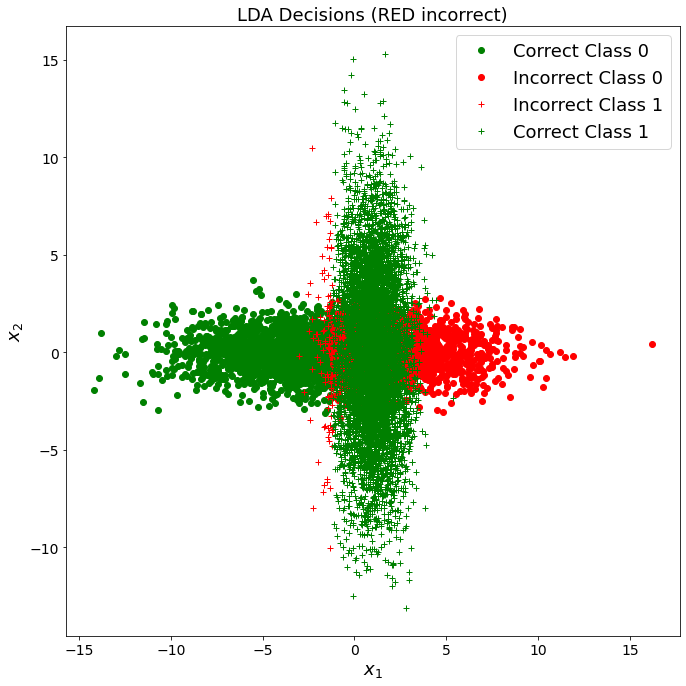

Smallest P(error) for ERM = 0.12319999999999999
Smallest P(error) for LDA = 0.18819999999999995


In [15]:
# Use min-error threshold
decisions_lda = discriminant_score_lda >= tau_lda[min_ind]

# Get indices and probability estimates of the four decision scenarios:
# (true negative, false positive, false negative, true positive)

# True Negative Probability
ind_00_lda = np.argwhere((decisions_lda==0) & (labels==0))
p_00_lda = len(ind_00_lda) / Nl[0]
# False Positive Probability
ind_10_lda = np.argwhere((decisions_lda==1) & (labels==0))
p_10_lda = len(ind_10_lda) / Nl[0]
# False Negative Probability
ind_01_lda = np.argwhere((decisions_lda==0) & (labels==1))
p_01_lda = len(ind_01_lda) / Nl[1]
# True Positive Probability
ind_11_lda = np.argwhere((decisions_lda==1) & (labels==1))
p_11_lda = len(ind_11_lda) / Nl[1]

# Display LDA decisions
fig = plt.figure(figsize=(10, 10))

# class 0 circle, class 1 +, correct green, incorrect red
plt.plot(X[ind_00_lda, 0], X[ind_00_lda, 1], 'og', label="Correct Class 0")
plt.plot(X[ind_10_lda, 0], X[ind_10_lda, 1], 'or', label="Incorrect Class 0")
plt.plot(X[ind_01_lda, 0], X[ind_01_lda, 1], '+r', label="Incorrect Class 1")
plt.plot(X[ind_11_lda, 0], X[ind_11_lda, 1], '+g', label="Correct Class 1")

plt.legend()
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("LDA Decisions (RED incorrect)")
plt.tight_layout()
plt.show()

print("Smallest P(error) for ERM = {}".format(prob_error_erm))
print("Smallest P(error) for LDA = {}".format(min_prob_error_lda))

Since the MAP classifier is designed to minimize probability error (when implemented with true class conditional likelihoods and class priors), we expected its error probability to be lower than that of all other classifiers, including Fisher's LDA. The numerical experiment is consistent with this theoretical result. 

We also note that since the dataset is random, occasionally (less frequently for larger N) the empirical error probability estimate of LDA may by chance be lower than that of the MAP classifier; those are due to random sample variations in error probability estimates using samples.

Also note that in this case, the ROC curve of the LDA classifier is nonconcave, clearly indicating a model mismatch -- the linear boundary is inappropriate for this case where a quadratic boundary is needed.